# **Predicting Apartment Price with Neighborhood**

In [3]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


# **Prepare Data**

## Import

In [4]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    #Extract Neighbor from the data
    df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns = "place_with_parent_names", inplace=True)

    return df

## **Task 1: Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files.**

In [5]:
files = glob("buenos-aires-real-estate-*.csv")
files

['buenos-aires-real-estate-3.csv',
 'buenos-aires-real-estate-2.csv',
 'buenos-aires-real-estate-1.csv',
 'buenos-aires-real-estate-5.csv',
 'buenos-aires-real-estate-4.csv']

## **Task 2: Use your wrangle function in a for loop to create a list named frames. The list should the cleaned DataFrames created from the CSV filenames your collected in files.**

In [6]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)
frames[0].head()

,Unnamed: 0,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
7,8,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
20,21,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
21,22,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
41,42,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
43,44,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


## **Task 3: Use pd.concat to concatenate the items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True.**

In [7]:
df = pd.concat(frames, ignore_index=True)
df.head()

,Unnamed: 0,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,8,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
1,21,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
2,22,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
3,42,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
4,44,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


# **Explore**

### **Looking through the output from the df.head() call above, there's a little bit more cleaning we need to do before we can work with the neighborhood information in this dataset. The good news is that, because we're using a wrangle function, we only need to change the function to re-clean all of our CSV files. This is why functions are so useful.**

### **Task 4: Modify your wrangle function to create a new feature "neighborhood". You can find the neighborhood for each property in the "place_with_parent_names" column. For example, a property with the place name "|Argentina|Capital Federal|Palermo|" is located in the neighborhood is "Palermo". Also, your function should drop the "place_with_parent_names" column.**

In [ ]:
  df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand=True)[3].head()

# **Split**

### **Task 5: Create your feature matrix X_train and target vector y_train. X_train should contain one feature: "neighborhood". Your target is "price_aprox_usd".**

In [8]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

# **Build Model**

## **Baseline**


### **Task 6: Calculate the baseline mean absolute error for your model.**

In [9]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


### **Task 7: First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. Next, fit your transformer to the feature matrix X_train. Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train.**

In [10]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Villa General Mitre,neighborhood_Palermo,neighborhood_Saavedra,neighborhood_Villa del Parque,neighborhood_Belgrano,neighborhood_Coghlan,neighborhood_Chacarita,neighborhood_Boedo,neighborhood_Caballito,neighborhood_Monserrat,...,neighborhood_Versalles,neighborhood_Villa Lugano,neighborhood_Parque Avellaneda,neighborhood_Las Cañitas,neighborhood_Villa Soldati,neighborhood_Parque Chas,neighborhood_Velez Sarsfield,neighborhood_Pompeya,neighborhood_Villa Real,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Task 8: Create a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor. Then fit your model to the training data.**

In [11]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

# **Evaluate**

**Task 9: First, create a list of predictions for the observations in your feature matrix X_train. Name this list y_pred_training. Then calculate the training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.**

In [12]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


**Task 10: Run the code below to import your test data buenos-aires-test-features.csv into a DataFrame and generate a Series of predictions using your model.**

In [14]:
X_test = pd.read_csv("buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

# **Communicate Results**

If we write out the equation for our model, it'll be too big to fit on the screen. That's because, when we used the OneHotEncoder to encode the neighborhood data, we created a much wider DataFrame, and each column/feature has it's own coefficient in our model's equation.

**Equation:** y = β0 + β1 x1 + β2 x2 + ... + β59 x59 + β60 x60

This is important to keep in mind for two reasons. First, it means that this is a high-dimensional model. Instead of a 2D or 3D plot, we'd need a 58-dimensional plot to represent it, which is impossible! Second, it means that we'll need to extract and represent the information for our equation a little differently than before. Let's start by getting our intercept and coefficient.


**Task 11: Extract the intercept and coefficients for your model.**

In [15]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[  7714.62159938  45934.4105851   14701.16243686 -12595.50084744
  46954.20800905]


**Task 12: Extract the feature names of your encoded data from the OneHotEncoder in your model.**

In [16]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Villa General Mitre' 'neighborhood_Palermo'
 'neighborhood_Saavedra' 'neighborhood_Villa del Parque'
 'neighborhood_Belgrano']


/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


**Task 13: Create a pandas Series named feat_imp where the index is your features and the values are your coefficients.**

In [17]:
feat_imp = pd.Series(coefficients, feature_names)
feat_imp.head()

neighborhood_Villa General Mitre     7714.621599
neighborhood_Palermo                45934.410585
neighborhood_Saavedra               14701.162437
neighborhood_Villa del Parque      -12595.500847
neighborhood_Belgrano               46954.208009
dtype: float64

**Task 14: Run the cell below to print the equation that your model has determined for predicting apartment price based on longitude and latitude.**

In [18]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (7714.62 * neighborhood_Villa General Mitre)
+ (45934.41 * neighborhood_Palermo)
+ (14701.16 * neighborhood_Saavedra)
+ (-12595.5 * neighborhood_Villa del Parque)
+ (46954.21 * neighborhood_Belgrano)
+ (12223.11 * neighborhood_Coghlan)
+ (-2898.96 * neighborhood_Chacarita)
+ (-6837.4 * neighborhood_Boedo)
+ (9252.89 * neighborhood_Caballito)
+ (-20292.6 * neighborhood_Monserrat)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (42831.32 * neighborhood_Nuñez)
+ (-11172.55 * neighborhood_Balvanera)
+ (5638.47 * neighborhood_San Telmo)
+ (2903.34 * neighborhood_Almagro)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-3427.44 * neighborhood_Monte Castro)
+ (72740.78 * neighborhood_Recoleta)
+ (-21078.78 * neighborhood_Mataderos)
+ (12671.71 * neighborhood_Villa Urquiza)
+ (-15807.01 * neighborhood_Parque Patricios)
+ (-8662.28 * neighborhood_Flores)
+ (-28353.36 * neighborhood_Boca)
+ (-14088.02 * neighborhood_Floresta)
+ (-10678.63 * neighborhood_San Cristobal)
+ (6277.

**Task 15: Scroll up, change the predictor in your model to Ridge, and retrain it. Then evaluate the model's training and test performance. Do you still have an overfitting problem? If not, extract the intercept and coefficients again (you'll need to change your code a little bit) and regenerate the model's equation. Does it look different than before?**

What's overfitting?

What's regularization?

What's ridge regression?

In [19]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

**Task 16: Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.**

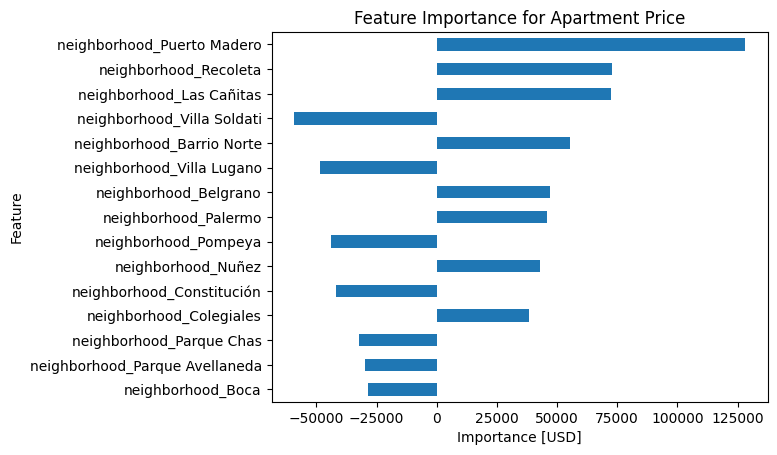

In [20]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");